In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jobathonsept/SAMPLE.csv
/kaggle/input/jobathonsept/TEST_FINAL.csv
/kaggle/input/jobathonsept/TRAIN.csv


### Step 1: Importing the Relevant Libraries

In [2]:
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

### Step 2: Data Inspection

In [3]:
df = pd.read_csv("../input/jobathonsept/TRAIN.csv")
df_test = pd.read_csv("../input/jobathonsept/TEST_FINAL.csv")
sample_submission = pd.read_csv("../input/jobathonsept/SAMPLE.csv")

In [4]:
df.shape,df_test.shape

((188340, 10), (22265, 8))

* __We have 188340 rows and 10 columns in Train set whereas Test set has 22265 rows and 8 columns.__

In [5]:
df.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


In [6]:
#categorical features
categorical = df.select_dtypes(include =[np.object])
print("Categorical Features in Train Set:",categorical.shape[1])

#numerical features
numerical= df.select_dtypes(include =[np.float64,np.int64])
print("Numerical Features in Train Set:",numerical.shape[1])

Categorical Features in Train Set: 6
Numerical Features in Train Set: 4


In [7]:
#categorical features
categorical = df_test.select_dtypes(include =[np.object])
print("Categorical Features in Test Set:",categorical.shape[1])

#numerical features
numerical= df_test.select_dtypes(include =[np.float64,np.int64])
print("Numerical Features in Test Set:",numerical.shape[1])

Categorical Features in Test Set: 6
Numerical Features in Test Set: 2


In [8]:
#ratio of null values in test data
df_test.isnull().sum()/df_test.shape[0] *100

ID               0.0
Store_id         0.0
Store_Type       0.0
Location_Type    0.0
Region_Code      0.0
Date             0.0
Holiday          0.0
Discount         0.0
dtype: float64

In [9]:
#ratio of null values in train data
df.isnull().sum()/df.shape[0] *100

ID               0.0
Store_id         0.0
Store_Type       0.0
Location_Type    0.0
Region_Code      0.0
Date             0.0
Holiday          0.0
Discount         0.0
#Order           0.0
Sales            0.0
dtype: float64

* __We don't have any of missing values in both the dataset.__

### Step 3: Data Cleaning

In [10]:
#reviewing the unique count of values per feature
for col in df.columns:
    print(col, df[col].nunique(), len(df))

ID 188340 188340
Store_id 365 188340
Store_Type 4 188340
Location_Type 5 188340
Region_Code 4 188340
Date 516 188340
Holiday 2 188340
Discount 2 188340
#Order 299 188340
Sales 47422 188340


In [11]:
for col in df_test.columns:
    print(col, df_test[col].nunique(), len(df_test))

ID 22265 22265
Store_id 365 22265
Store_Type 4 22265
Location_Type 5 22265
Region_Code 4 22265
Date 61 22265
Holiday 2 22265
Discount 2 22265


We can safely remove “ID” column as most values are unique for this feature.

__Manually converting categorical columns to numerical.__

In [12]:
df.Store_Type.value_counts()

S1    88752
S4    45924
S2    28896
S3    24768
Name: Store_Type, dtype: int64

In [13]:
df.Store_Type.replace({'S1': 1, 'S2': 2, 'S3': 3,'S4': 4}, inplace=True)
df_test.Store_Type.replace({'S1': 1, 'S2': 2, 'S3': 3,'S4': 4}, inplace=True)

In [14]:
df.Location_Type.value_counts()

L1    85140
L2    48504
L3    29928
L5    13932
L4    10836
Name: Location_Type, dtype: int64

In [15]:
df.Location_Type.replace({'L1': 1, 'L2': 2, 'L3': 3,'L4': 4,'L5':5}, inplace=True)
df_test.Location_Type.replace({'L1': 1, 'L2': 2, 'L3': 3,'L4': 4,'L5':5}, inplace=True)

In [16]:
df.Region_Code.value_counts()

R1    63984
R2    54180
R3    44376
R4    25800
Name: Region_Code, dtype: int64

In [17]:
df.Region_Code.replace({'R1': 1, 'R2': 2, 'R3': 3,'R4': 4}, inplace=True)
df_test.Region_Code.replace({'R1': 1, 'R2': 2, 'R3': 3,'R4': 4}, inplace=True)

In [18]:
df.Discount.value_counts()

No     104051
Yes     84289
Name: Discount, dtype: int64

In [19]:
df.Discount.replace({'No': 0, 'Yes': 1}, inplace=True)
df_test.Discount.replace({'No': 0, 'Yes': 1}, inplace=True)

__Creating K folds__

In [20]:
df['kfold']= -1

In [21]:
kf = model_selection.KFold(n_splits=5,shuffle = True,random_state = 42)
for fold,(train_indicies, valid_indicies) in enumerate(kf.split(X=df)):
    df.loc[valid_indicies, 'kfold'] = fold

In [22]:
df.head()

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales,kfold
0,T1000001,1,1,3,1,2018-01-01,1,1,9,7011.84,0
1,T1000002,253,4,2,1,2018-01-01,1,1,60,51789.12,3
2,T1000003,252,3,2,1,2018-01-01,1,1,42,36868.20,3
3,T1000004,251,2,3,1,2018-01-01,1,1,23,19715.16,2
4,T1000005,250,2,3,4,2018-01-01,1,1,62,45614.52,1


In [23]:
df['kfold'].value_counts()

0    37668
1    37668
2    37668
3    37668
4    37668
Name: kfold, dtype: int64

Each fold have same number of rows.

### Step 4: Exploratory Data Analysis

In [24]:
df.columns

Index(['ID', 'Store_id', 'Store_Type', 'Location_Type', 'Region_Code', 'Date',
       'Holiday', 'Discount', '#Order', 'Sales', 'kfold'],
      dtype='object')

<AxesSubplot:xlabel='Store_Type', ylabel='count'>

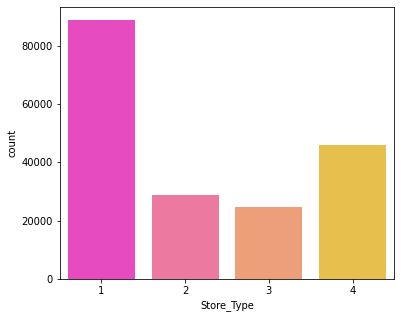

In [25]:
plt.figure(figsize=(6,5))
sns.countplot('Store_Type',data=df,palette='spring')

<AxesSubplot:xlabel='Location_Type', ylabel='count'>

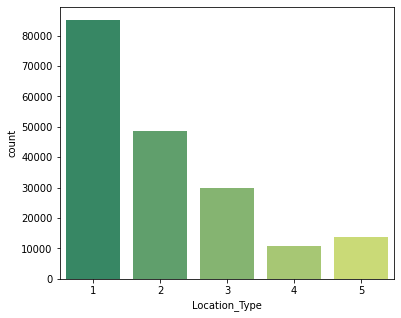

In [26]:
plt.figure(figsize=(6,5))
sns.countplot('Location_Type',data=df,palette='summer')

<AxesSubplot:xlabel='Region_Code', ylabel='count'>

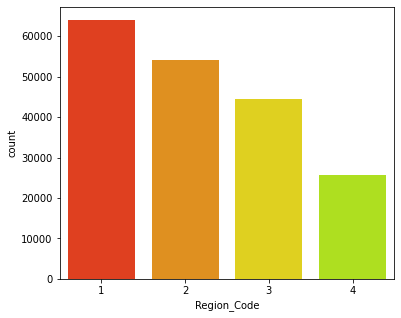

In [27]:
plt.figure(figsize=(6,5))
sns.countplot('Region_Code',data=df,palette='prism')

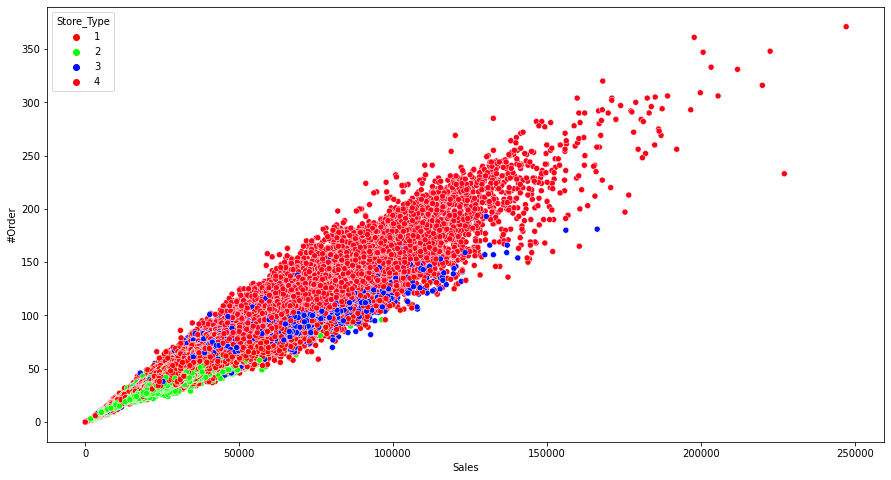

In [28]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='Sales' ,y='#Order', hue ='Store_Type',data=df , palette='hsv' );

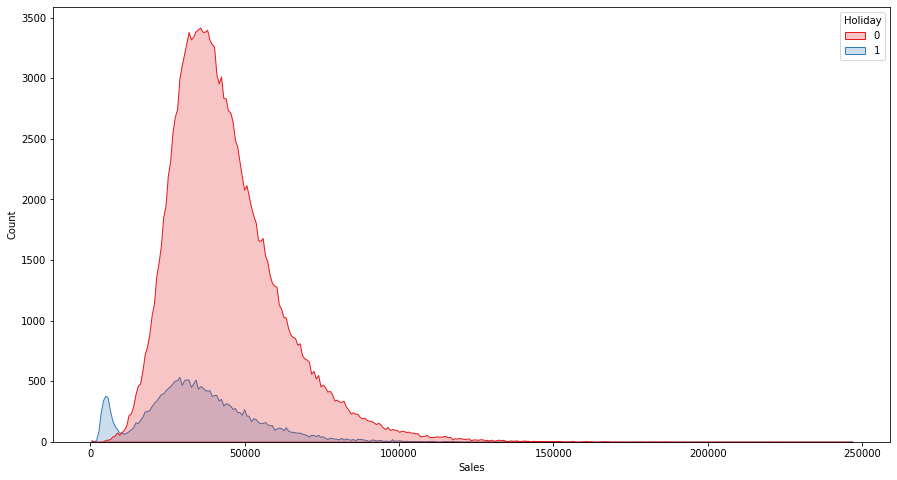

In [29]:
plt.figure(figsize=(15,8))
sns.histplot(x='Sales' ,hue='Holiday' , data=df ,element="poly", palette='Set1' );

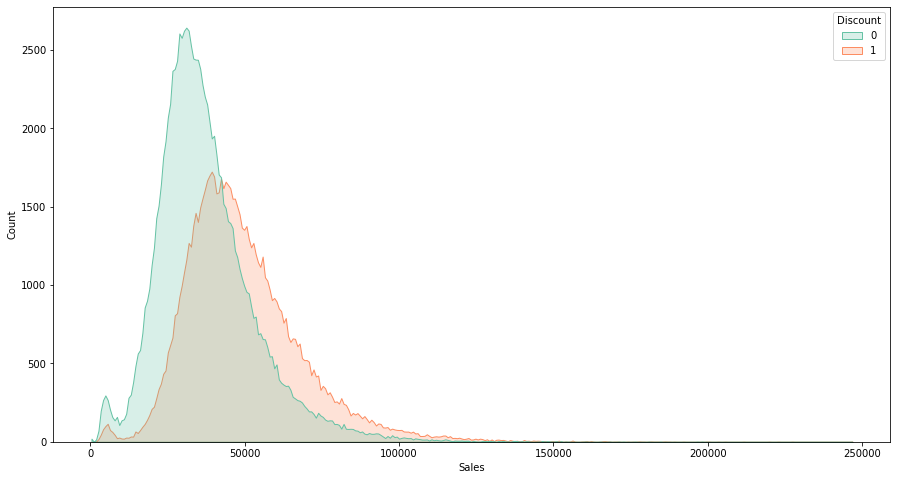

In [30]:
plt.figure(figsize=(15,8))
sns.histplot(x='Sales' ,hue='Discount' , data=df ,element="poly", palette='Set2' );

### Step 5: Feature Engineering & Model Building

In [31]:
useful_features = [c for c in df.columns if c not in ("ID",'Date',"#Order",'Sales','kfold')]
object_cols = [col for col in useful_features if 'cat' in col]
numerical_cols = [col for col in useful_features if 'cont' in col]
df_test = df_test[useful_features]

In [32]:
final_predictions1 = []
scores =[]

for fold in range(5):
    xtrain = df[df.kfold != fold].reset_index(drop=True)
    xvalid = df[df.kfold == fold].reset_index(drop=True)
    xtest = df_test.copy()

    ytrain = xtrain.Sales
    yvalid = xvalid.Sales

    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    
    #One-hot encoding
    ohe = preprocessing.OneHotEncoder(sparse=False, handle_unknown="ignore")
    xtrain_ohe = ohe.fit_transform(xtrain[object_cols])
    xvalid_ohe = ohe.transform(xvalid[object_cols])
    xtest_ohe = ohe.transform(xtest[object_cols])
    
    xtrain_ohe = pd.DataFrame(xtrain_ohe, columns=[f"ohe_{i}" for i in range(xtrain_ohe.shape[1])])
    xvalid_ohe = pd.DataFrame(xvalid_ohe, columns=[f"ohe_{i}" for i in range(xvalid_ohe.shape[1])])
    xtest_ohe = pd.DataFrame(xtest_ohe, columns=[f"ohe_{i}" for i in range(xtest_ohe.shape[1])])
    
    xtrain = pd.concat([xtrain, xtrain_ohe], axis=1)
    xvalid = pd.concat([xvalid, xvalid_ohe], axis=1)
    xtest = pd.concat([xtest, xtest_ohe], axis=1)
    
    xtrain = xtrain.drop(object_cols, axis=1)
    xvalid = xvalid.drop(object_cols, axis=1)
    xtest = xtest.drop(object_cols, axis=1)
    
    #model building
    model = XGBRegressor(random_state=56,
        tree_method="gpu_hist",
        gpu_id=0,
        predictor="gpu_predictor",
        n_estimators= 7407,
        learning_rate= 0.16225741396188204,
        reg_lambda= 0.004245750176668119,
        reg_alpha= 1.8712506669906937e-05,
        subsample= 0.3307188875642757,
        colsample_bytree= 0.8942876675734405,
        max_depth= 9)
    
    model.fit(xtrain,ytrain)
    preds_valid = model.predict(xvalid)
    test_preds = model.predict(xtest)
    final_predictions1.append(test_preds)
    msle = mean_squared_log_error(yvalid, preds_valid)
    print(fold, msle)
    scores.append(msle)
    
print(np.mean(scores), np.std(scores))

0 0.09975641677880165
1 0.1055535822944306
2 0.11141787711957009
3 0.10578280253292917
4 0.10493148438209374
0.10548843262156504 0.0036990649397558306


In [33]:
preds = np.mean(np.column_stack(final_predictions1), axis=1)

In [34]:
sample_submission.Sales = preds
sample_submission.to_csv("sample_submission_final.csv", index=False)